In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Import required Libraries**

In [ ]:
 pip install -q tensorflow-model-optimization

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow_model_optimization.python.core.keras.compat import keras

# Load Data

In [ ]:
batch_size = 64
img_height = 224
img_width = 224

data_dir = "/content/drive/MyDrive/New Folder/TinyML/Datasets/Tomatoes Diseases/"

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
    data_dir + "Train",
    validation_split=0.2,
    subset="training",
    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
)

Found 12860 files belonging to 10 classes.
Using 10288 files for training.


In [ ]:
val_ds = keras.utils.image_dataset_from_directory(
    data_dir + "Train",
    validation_split=0.2,
    subset="validation",
    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
)

Found 12860 files belonging to 10 classes.
Using 2572 files for validation.


In [ ]:

class_names = train_ds.class_names
class_names

['Bacterial_spot',
 'Early_blight',
 'Late_blight',
 'Leaf_Mold',
 'Septoria_leaf_spot',
 'Spider_mites_Two_spotted_spider_mite',
 'Target_Spot',
 'Yellow_Leaf__Curl_Virus',
 'healthy',
 'mosaic_virus']

# **Visualize the data**

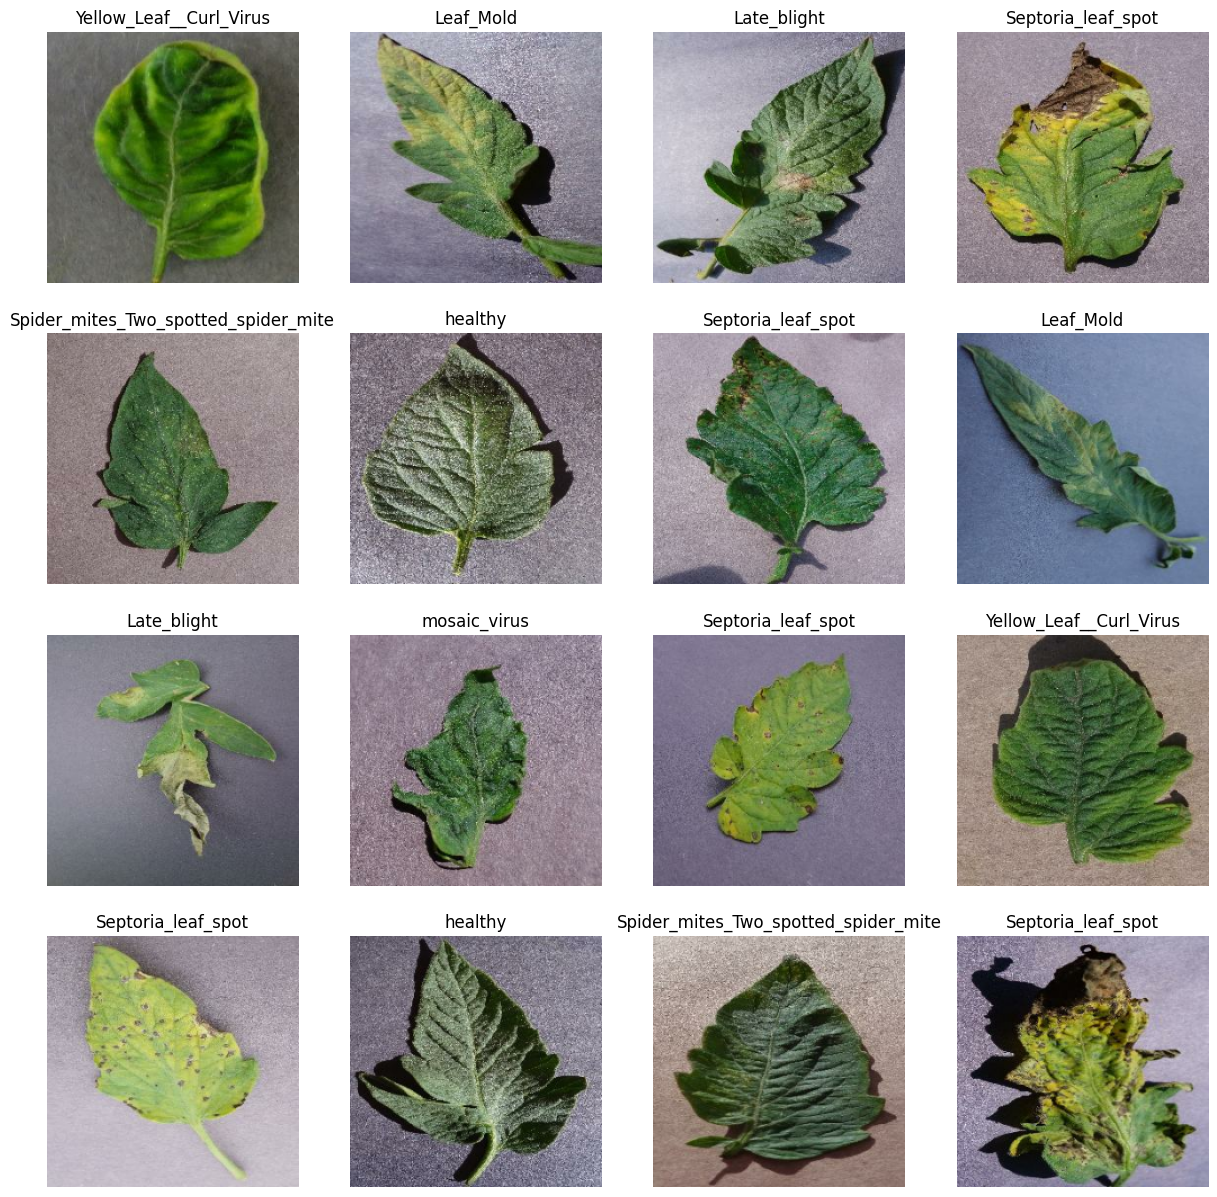

In [ ]:
plt.figure(figsize=(15, 15))
for img, lab in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(class_names[lab[i]])
        plt.axis("off")

# Preprocess the data

In [ ]:
# set 8000 images for training and 1024 images for validation
train_nds = train_ds.take(125)
val_nds = val_ds.take(16)

In [ ]:
for i, j in val_nds.take(1):
    print(i.shape)
    print(j.shape)
    break

In [ ]:
# Configure the dataset for performance

AUTOTUNE = tf.data.AUTOTUNE

train_nds = train_nds.cache().prefetch(buffer_size=AUTOTUNE)
val_nds = val_nds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
print(train_nds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


# **Train a model**

In [ ]:
# define alexnet model

AlexNet = keras.Sequential([

    keras.layers.Rescaling(1.0/255, input_shape=(img_height, img_width, 3)),

    keras.layers.Conv2D(96, kernel_size=(11, 11), strides=(4,4), activation='relu', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2,2)),

    keras.layers.Conv2D(256, kernel_size=(5, 5), strides=(1,1), padding='same', activation='relu', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2,2)),

    keras.layers.Conv2D(384, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(384, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(256, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2,2)),

    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dropout(0.7),

    keras.layers.Dense(4096, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dropout(0.7),

    keras.layers.Dense(10, activation='softmax')  # 10 classes
])



AlexNet.compile(
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  optimizer=keras.optimizers.Adam(learning_rate=1e-5),
  metrics=["accuracy"]
)
# Model summary

AlexNet.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 54, 54, 96)        34944     
                                                                 
 batch_normalization_5 (Bat  (None, 54, 54, 96)        384       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 26, 26, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 batch_normalization_6 (Bat  (None, 26, 26, 256)      

In [ ]:
# training the alexnet model

AlexNet_history = AlexNet.fit(
    train_nds,
    validation_data=val_nds,
    epochs=100
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/tf_keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


125/125 [==============================] - 1348s 10s/step - loss: 8.7807 - accuracy: 0.2097 - val_loss: 2.2613 - val_accuracy: 0.2314
Epoch 2/100
125/125 [==============================] - 11s 90ms/step - loss: 4.8093 - accuracy: 0.3525 - val_loss: 2.4955 - val_accuracy: 0.3066
Epoch 3/100
125/125 [==============================] - 12s 95ms/step - loss: 3.3040 - accuracy: 0.4209 - val_loss: 1.7978 - val_accuracy: 0.4531
Epoch 4/100
125/125 [==============================] - 11s 87ms/step - loss: 2.5560 - accuracy: 0.4710 - val_loss: 1.2143 - val_accuracy: 0.6094
Epoch 5/100
125/125 [==============================] - 11s 87ms/step - loss: 2.0280 - accuracy: 0.5224 - val_loss: 0.9866 - val_accuracy: 0.6670
Epoch 6/100
125/125 [==============================] - 11s 87ms/step - loss: 1.8007 - accuracy: 0.5381 - val_loss: 0.8798 - val_accuracy: 0.7041
Epoch 7/100
125/125 [==============================] - 11s 87ms/step - loss: 1.5912 - accuracy: 0.5635 - val_loss: 0.8077 - val_accuracy: 0.7

# **Visualize the training results**

In [ ]:
def plot_curves(his):

    loss = his.history['loss']
    val_loss = his.history['val_loss']

    accuracy = his.history['accuracy']
    val_accuracy = his.history['val_accuracy']

    epochs = range(len(his.history['loss']))

    # ploting the loss
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.figure()

    # ploting the accuracy
    plt.plot(epochs, accuracy, 'r', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.figure()


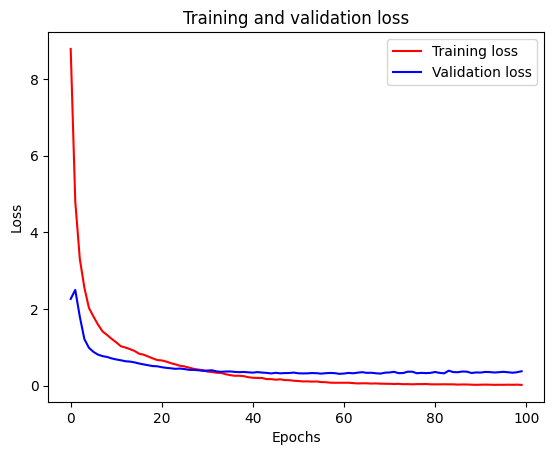

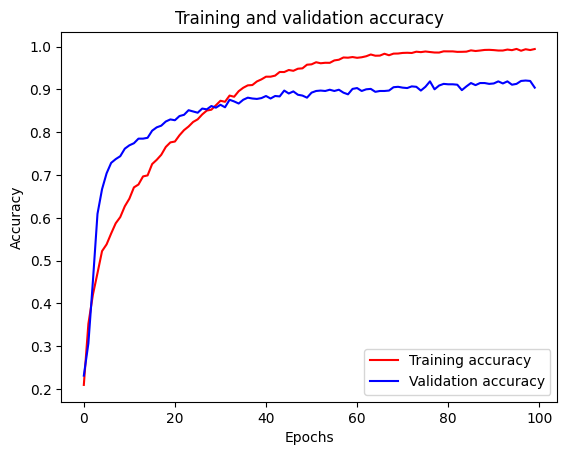

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_curves(AlexNet_history)

In [ ]:
# saving the model to the disk

model = "/content/drive/MyDrive/New Folder/TinyML/SaveModels/AlexNet.h5"
keras.models.save_model(AlexNet, model, include_optimizer=False)

<ipython-input-28-381cbcfdd3c4>:4: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  keras.models.save_model(AlexNet, model, include_optimizer=False)


# **Testing the model**

In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir + "Test",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
)

Found 3198 files belonging to 10 classes.


In [ ]:
class_names = test_ds.class_names
class_names

['Bacterial_spot',
 'Early_blight',
 'Late_blight',
 'Leaf_Mold',
 'Septoria_leaf_spot',
 'Spider_mites_Two_spotted_spider_mite',
 'Target_Spot',
 'Yellow_Leaf__Curl_Virus',
 'healthy',
 'mosaic_virus']

In [ ]:
test_ds = test_ds.take(16)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

test_nds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
loss, acc = AlexNet.evaluate(test_nds)
print("Accuracy", acc)
print("Loss", loss)

16/16 [==============================] - 1s 54ms/step - loss: 0.3857 - accuracy: 0.9199
Accuracy 0.919921875
Loss 0.3856890797615051


In [ ]:
# Get predictions
y_pred = AlexNet.predict(test_nds)
y_pred = np.argmax(y_pred, axis=1)

# Get true labels
y_true = np.concatenate([y for x, y in test_nds], axis=0)

# Compute confusion matrix
cm = tf.math.confusion_matrix(y_true, y_pred)

16/16 [==============================] - 1s 43ms/step


In [ ]:
cm

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[120,   1,   0,   0,   0,   0,   0,   1,   0,   0],
       [  2,  32,  10,   0,   7,   2,   1,   1,   0,   0],
       [  1,   2, 112,   4,   8,   0,   1,   0,   0,   0],
       [  0,   0,   0,  52,   4,   3,   1,   1,   0,   0],
       [  0,   0,   2,   0, 111,   0,   0,   0,   0,   0],
       [  0,   1,   0,   1,   0, 101,   3,   1,   0,   2],
       [  0,   0,   1,   0,   3,   7,  77,   2,   2,   1],
       [  1,   0,   0,   0,   0,   2,   0, 207,   0,   0],
       [  0,   0,   0,   0,   2,   0,   0,   0, 104,   0],
       [  0,   0,   0,   0,   1,   0,   0,   0,   0,  26]], dtype=int32)>

Text(0.5, 1.0, 'Confusion Matrix')

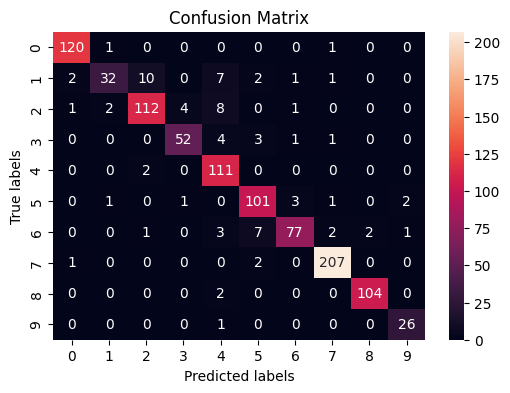

In [ ]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

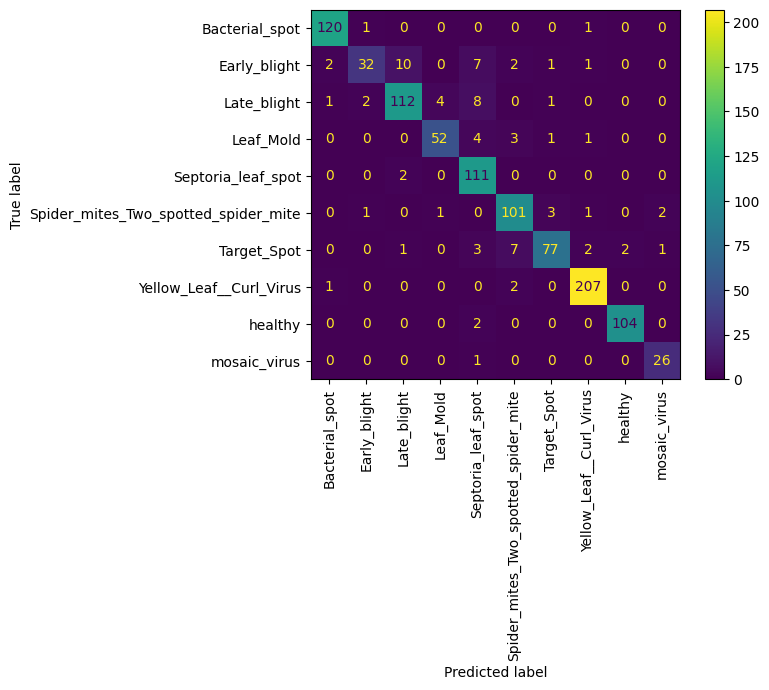

In [ ]:
ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred, display_labels=class_names, xticks_rotation='vertical'
)

In [ ]:
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Accuracy", acc)
print("Loss", loss)

Precision: 0.9136574495179215
Recall: 0.8959556458527841
F1 Score: 0.9002416773313202
Accuracy 0.3856890797615051
Loss 0.919921875
